In [103]:
if '__IPYTHON__' in globals():
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

import numpy as np
import pandas as pd
import squarify
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson, norm, chi2_contingency
from statsmodels.stats.weightstats import ztest


from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (8,6)
pd.options.display.max_rows = 10
pd.options.display.max_columns = 100


### Functions

In [104]:
def replace_labels(ax, char, axis='y'):
    # Customize y-labels
    if axis == 'x':
        _ = ticks_loc = ax.get_xticks().tolist()
        _ = ax.set_xticks(ticks_loc)
        _ = ax.set_xticklabels([f'{x:,.0f}{char}' for x in ticks_loc])
    if axis == 'y':
        _ = ticks_loc = ax.get_yticks().tolist()
        _ = ax.set_yticks(ticks_loc)
        _ = ax.set_yticklabels([f'{x:,.0f}{char}' for x in ticks_loc])
    
def perform_anderson_test(data):
	result = anderson(data)
	print('Statistic = %.2f' % result.statistic)

	p = 0
	for i in range(len(result.critical_values)):
		sl, cv = result.significance_level[i], result.critical_values[i]
		if result.statistic < result.critical_values[i]:
			print(f'significance level = {sl:.2f}, critical value = {cv:.2f}, (fail to reject H0)')
		else:
			print(f'significance level = {sl:.2f}, critical value = {cv:.2f}, (reject H0)')
	print('\n')

def get_test_result(name, score, p_value, significance=0.05):
    # Test the p-value
    print(f"{name}")
    print(f"Score: {score:0.2f} and p-value: {p_value:0.2f}")
    if (p_value < significance):
        print(f'H0 can be rejected!')
    else:
        print('Fail to reject H0')

def custom_countplot(x, y, **kwargs):
    ax = sns.barplot(x=x, y=y, estimator=lambda x: len(x) / len(df) * 100)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    replace_labels(ax, "%")

### 1. Import dataset


In [105]:
df = pd.read_csv("../data/raw/train.csv")

### 2. Explore data

This dataset has:

5 discrete numerical variables: *PassengerId, Survived, Pclass, SibSp, Parch*

2 numerical continuous variables: *Age, Fare*

5 categorical variables: *Name, Sex, Ticket, Cabin, Embarked*

In [106]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [107]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The data seems to haven't wrong values, like negative *Age, Parch* or *Fare*

In [108]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [109]:

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [110]:

df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


The *Cabin* feature has many missing values, maybe be useless for modeling without any additional treatment

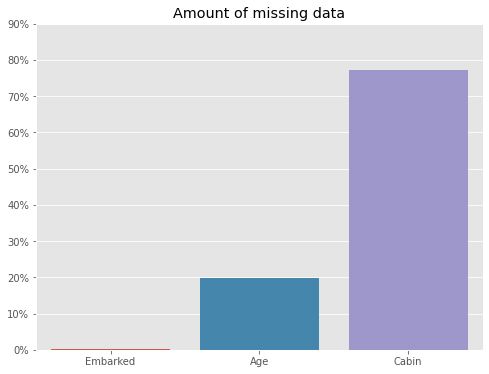

In [111]:

# Get  only columns with missing data
missing_data = (df.isnull().sum() / len(df)) *100
missing_data = missing_data[missing_data > 0].sort_values()
missing_data

# Plot data
g = sns.barplot(x=missing_data.index, y=missing_data.values)
g.set_title('Amount of missing data')

# Replace y-axis labels
replace_labels(g,'%')

### 2.1 Data Distribution


#### Overall

About 62% of the passengers listed in this data set survived.

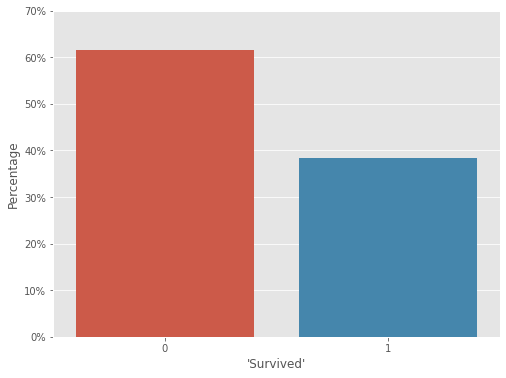

In [112]:
survived = df['Survived'].value_counts(normalize=True)*100
_ = ax = sns.barplot(x=survived.index, y=survived)
_ = ax.set_xlabel("'Survived'")
_ = ax.set_ylabel("Percentage")
replace_labels(ax, "%")

#### Categorical

* About 65% of the passengers were men
* 72% of the travelers embarked on Southampton, roughly 19% in Cherbourg, and 8% in Queenstown.
* 55% were 1st-class, 24% 2nd-class, and rougly 21% 3rd-class.

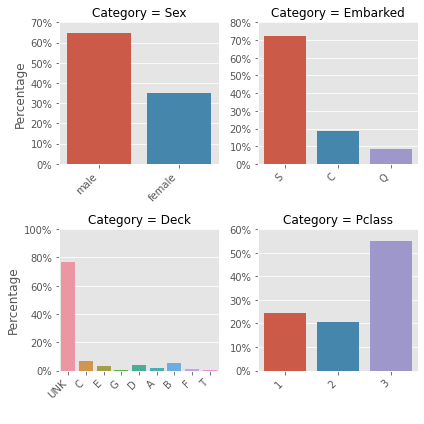

In [113]:

df["Deck"] = df["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else 'UNK')

categorical = df[["Sex", "Embarked", "Survived","Deck", "Pclass"]]
melted_cat_vars = pd.melt(categorical, id_vars=["Survived"],var_name='Category')
g = sns.FacetGrid(
        melted_cat_vars, col="Category", sharex=False, sharey=False, col_wrap=2
    )
g.map(custom_countplot, "value", "Survived")
g.set_axis_labels(y_var="Percentage",x_var=" ")
plt.tight_layout()

#### Numerical

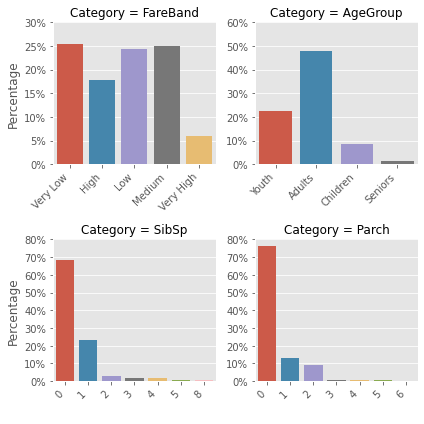

In [114]:
df['FareBand'] = pd.cut(df['Fare'], bins=[0, 8, 15, 32, 100, 600], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df['AgeGroup'] = pd.cut(df['Age'], [0,14,24,64, 150], labels=['Children','Youth','Adults','Seniors'])

numerical = df[["FareBand", "AgeGroup", "SibSp", "Parch", "Survived"]]

melted_num_vars = pd.melt(numerical, id_vars=["Survived"],var_name='Category')

g = sns.FacetGrid(
        melted_num_vars, col="Category", sharex=False, sharey=False, col_wrap=2
    )
g.map(custom_countplot, "value", "Survived")
g.set_axis_labels(y_var="Percentage",x_var=" ")
plt.tight_layout()

### 2.2 Analyzing Survivors & Testing Hypothesis

#### Socio-economic

Grouping survivors by class we see that on average 63% of the passengers of the 1st class survived, 47.23% of the 2nd and only 24.24% in the 3rd. This leads us to infer that the social class had influence in the survivors outcome.

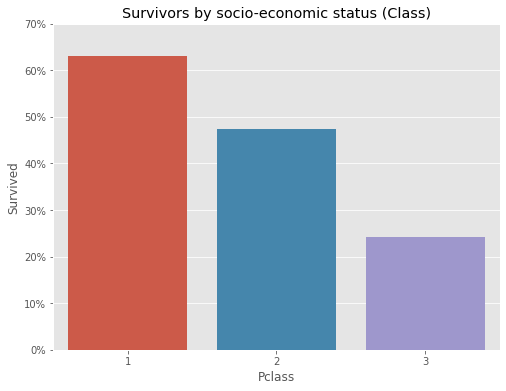

In [115]:

pclass_surv = df[["Survived", "Pclass"]].groupby("Pclass", as_index=False).mean()
g = sns.barplot(x=pclass_surv['Pclass'], y=pclass_surv['Survived']*100)
g.set_title('Survivors by socio-economic status (Class)')
replace_labels(g, '%')


**Not Fair assumptions**


Because we are working on a sample of the population data (all passengers), the assumption above may be not valid for some reasons:

* We don't know if this sample is representative.

* We don't know If it was randomly sampled and if the samples are independent.

So, hypothesis tests can be used to verify the sample data has evidence to accept or reject a hypothesis made about the population, in this case; if are a significant difference between the survivors from the 1st and 3rd class.

&emsp;&emsp;$H_0$: "Nothing special if going on" (The socio-economic status don't affected the survival rate).<br>
&emsp;&emsp;$H_A$: "There's a difference between survivors rate by socio-economic status"

in another words, if:

$p_1$ = proportion of survivors on 1st class and $p_2$ = proportion of survivors on 3rd class<br>
"Nothing unusual is going on" mean $p_1=p_2$ or $p_1 - p_2 = 0$.

&emsp;&emsp;$H_0$: $p_1 - p_2 = 0$<br>
&emsp;&emsp;$H_A$: $p_2 - p_1 \neq 0$

Proportions of two populations are under test, the z-test will be appropriated. The z-test assumes two normally distributed populations, but we don't have the population distribution, only the samples, so the *Central Limit Theorem* can be used. the CLT states that:

> "If you have a population with mean μ and standard deviation σ and take sufficiently large random samples from the population with replacement, then the distribution of the sample means will be approximately normally distributed." [Boston University](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_probability/BS704_Probability12.html#:~:text=The%20central%20limit%20theorem%20states,will%20be%20approximately%20normally%20distributed.)

Then, if we take some subsamples with replacement, the subsample proportions will follow the normal distribution, then the z-test can be applied.

To decide if the $H_0$ will be accepted or rejected, the p-value of 5% will be used.


In [116]:

contingency_table = pd.crosstab(df['Pclass'],df['Survived'])
chi2, p, _ , _ = chi2_contingency(contingency_table)
get_test_result(name="H0: Survival rate and socio-economic class aren't correlated", score=chi2, p_value=p)

H0: Survival rate and socio-economic class aren't correlated
Score: 102.89 and p-value: 0.00
H0 can be rejected!


The p-value is smaller than 0.05 which indicates that we can reject $H_0$, and there's a correlation between socio-economic class and survival rate.

#### Gender

On average 74% of the women survived against roughly 19% of the men, contrasting with the fact that men were the majority aboard.

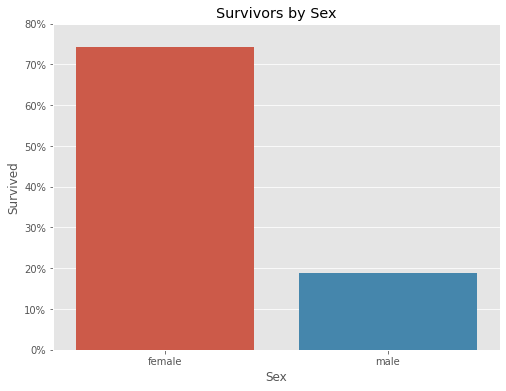

In [117]:

sex_surv = df[["Survived", "Sex"]].groupby("Sex", as_index=False).mean()
g = sns.barplot(x=sex_surv["Sex"], y=sex_surv["Survived"]*100)
g.set_title('Survivors by Sex')
replace_labels(g, '%')

In [118]:

contingency_table = pd.crosstab(df['Sex'],df['Survived'])
chi2, p, _ , _ = chi2_contingency(contingency_table)
get_test_result(name="H0: Gender and survival rate aren't correlated", score=chi2, p_value=p)

H0: Gender and survival rate aren't correlated
Score: 260.72 and p-value: 0.00
H0 can be rejected!


### Family Size

People accompanied by spouses, brother, sister, stepbrother, stepsister, or accompanied by at least three relatives had more chance of surviving.

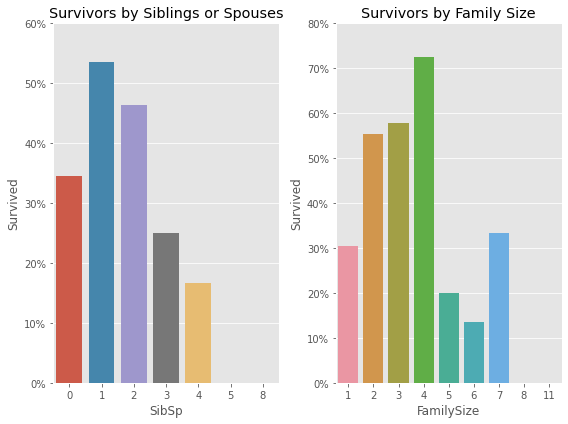

In [119]:

surv_family = df[["Survived", "SibSp"]].groupby("SibSp", as_index=False).mean()

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
surv_sibsp = df[["Survived", "FamilySize"]].groupby("FamilySize", as_index=False).mean()


_, axs = plt.subplots(1,2)

g0 = sns.barplot(x=surv_family["SibSp"], y=surv_family["Survived"]*100, ax=axs[0])
g0.set_title('Survivors by Siblings or Spouses')
replace_labels(g0, '%')

g1 = sns.barplot(x=surv_sibsp["FamilySize"], y=surv_sibsp["Survived"]*100)
g1.set_title('Survivors by Family Size')
replace_labels(g1, '%')

plt.tight_layout()

In [120]:

contingency_table = pd.crosstab(df['SibSp'],df['Survived'])
chi2, p, _ , _ = chi2_contingency(contingency_table)
get_test_result(name="H0: Survival rate is independent from the number of siblings, or spouses", score=chi2, p_value=p)

H0: Survival rate is independent from the number of siblings, or spouses
Score: 37.27 and p-value: 0.00
H0 can be rejected!


In [121]:

contingency_table = pd.crosstab(df['FamilySize'],df['Survived'])
chi2, p, _ , _ = chi2_contingency(contingency_table)
get_test_result(name="H0: Survival rates are independent from the family size", score=chi2, p_value=p)

H0: Survival rates are independent from the family size
Score: 80.67 and p-value: 0.00
H0 can be rejected!


Alone people survived less

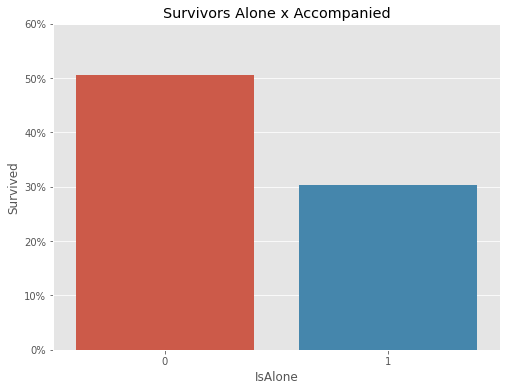

In [122]:

df["IsAlone"] = 0
df.loc[df["FamilySize"] == 1, "IsAlone"] = 1
surv_alone = df[["Survived", "IsAlone"]].groupby(["IsAlone"], as_index=False).mean()
g = sns.barplot(x=surv_alone["IsAlone"], y=surv_alone["Survived"]*100)
g.set_title("Survivors Alone x Accompanied")
replace_labels(g, "%")

In [123]:

contingency_table = pd.crosstab(df['IsAlone'],df['Survived'])
chi2, p, _ , _ = chi2_contingency(contingency_table)
get_test_result(name="H0: Survival rate are independent if you're alone or not", score=chi2, p_value=p)

H0: Survival rate are independent if you're alone or not
Score: 36.00 and p-value: 0.00
H0 can be rejected!


#### Local of Embark

On average more people who embarked in Cherbourg survived. <br>
(C = Cherbourg, Q = Queenstown, S = Southampton')

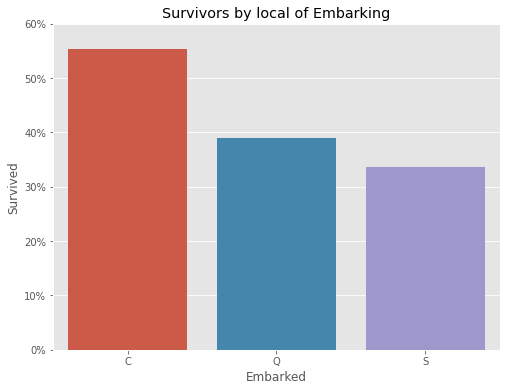

In [124]:

surv_embarked = df[["Survived", "Embarked"]].groupby("Embarked", as_index=False).mean()
g = sns.barplot(x=surv_embarked["Embarked"], y=surv_embarked["Survived"]*100)
g.set_title('Survivors by local of Embarking')
replace_labels(g, '%')

In [125]:
contingency_table = pd.crosstab(df['Embarked'],df['Survived'])
chi2, p, _ , _ = chi2_contingency(contingency_table)
get_test_result(name="H0: The embark local was not important for the survival rate", score=chi2, p_value=p)

H0: The embark local was not important for the survival rate
Score: 26.49 and p-value: 0.00
H0 can be rejected!


#### FareBand

Rich people, as also shown by Pclass plot, have survived more.

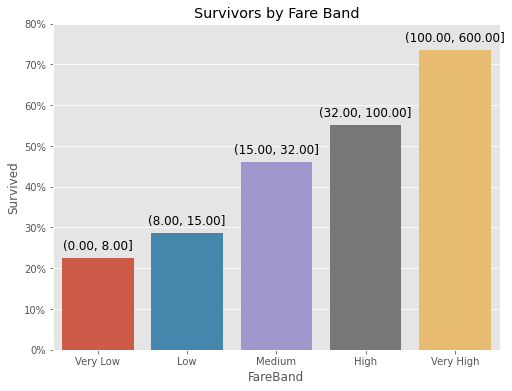

In [126]:

g = sns.barplot(x=df["FareBand"], y=df["Survived"]*100, ci=None)
bins=[0, 8, 15, 32, 100, 600]
# Plot the FareBand intervals above each bar
for i, bar in enumerate(g.patches):
    g.annotate(f"({bins[i]:0.2f}, {bins[i+1]:0.2f}]",
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()+1), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
g.set_title('Survivors by Fare Band')
replace_labels(g, '%')

In [127]:

contingency_table = pd.crosstab(df['FareBand'],df['Survived'])
chi2, p, _ , _ = chi2_contingency(contingency_table)
get_test_result(name="H0: There is no correlation between the survival rate and the fare paid by the passenger", score=chi2, p_value=p)

H0: There is no correlation between the survival rate and the fare paid by the passenger
Score: 83.92 and p-value: 0.00
H0 can be rejected!


Before analyzing the ages, we need to fill in a few missing values. If the data followed the normal distribution, the mean would be a good guess, but this is not the case, as you can see by the Anderson test result.

In [128]:

print("Null hypothesis (H0): Age follows the normal curve")
perform_anderson_test(df['Age'].dropna())

Null hypothesis (H0): Age follows the normal curve
Statistic = 3.82
significance level = 15.00, critical value = 0.57, (reject H0)
significance level = 10.00, critical value = 0.65, (reject H0)
significance level = 5.00, critical value = 0.78, (reject H0)
significance level = 2.50, critical value = 0.91, (reject H0)
significance level = 1.00, critical value = 1.09, (reject H0)




Looking at the Age histogram the ages seems a bit right skewed, so i will use the median to fill missing data. The median of each Pclass will be used.

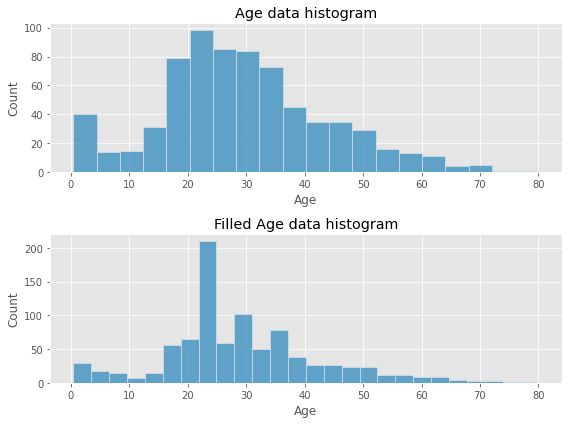

In [129]:

_, ax = plt.subplots(2,1)

# Save the old value of Age data
old_age = df['Age'].copy()

df["Age"] = df["Age"].fillna(df.groupby("Pclass")["Age"].transform("median"))

g0 = sns.histplot(old_age, ax=ax[0])
_ = g0.set_title('Age data histogram')

g1 = sns.histplot(df['Age'], ax=ax[1])
_ = g1.set_title('Filled Age data histogram')

plt.tight_layout()

Children and Youth survived more, analyzing by the sex, this difference is bigger as higher age

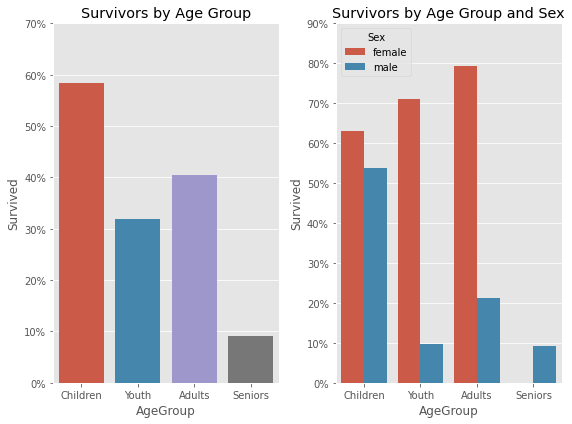

In [130]:

_, ax= plt.subplots(1,2)

df['AgeGroup'] = pd.cut(df['Age'], [0,14,24,64, 150], labels=['Children','Youth','Adults','Seniors'])

surv_agegroup = df[["Survived", "AgeGroup"]].groupby(["AgeGroup"], as_index=False).mean()
surv_agegroup['Survived'] *= 100

surv_agegroup_sex = df[["Survived","Sex", "AgeGroup"]].groupby(["AgeGroup","Sex"], as_index=False).mean()
surv_agegroup_sex['Survived'] *= 100


g0 = sns.barplot(data=surv_agegroup, x="AgeGroup", y="Survived", ax=ax[0])

g1 = sns.barplot(data=surv_agegroup_sex, x="AgeGroup", y="Survived", hue="Sex", ax=ax[1])

_ = g0.set_title('Survivors by Age Group')
replace_labels(g0, '%')

_ = g1.set_title('Survivors by Age Group and Sex')
replace_labels(g1, '%')

plt.tight_layout()


By analyzing the name, we can extract the title. Below you can see the passengers of the Titanic by their titles.

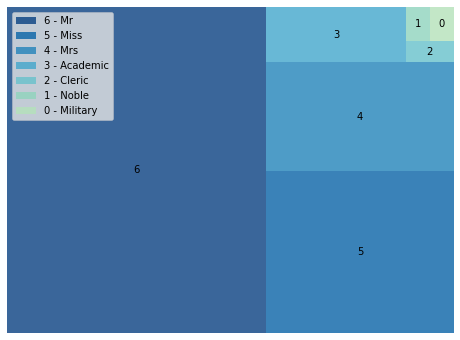

In [131]:

# Extract only title from the name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Replace titles
df['Title'] = df['Title'].replace(['Rev'], 'Cleric')
df['Title'] = df['Title'].replace(['Don', 'Countess', 'Sir', 'Lady', 'Jonkheer'], 'Noble')
df['Title'] = df['Title'].replace(['Col', 'Capt','Major'], 'Military')
df['Title'] = df['Title'].replace(['Mlle','Mme', 'Ms'],'Miss')
df['Title'] = df['Title'].replace(['Master','Dr'],'Academic')

# Plot
colors = cm.GnBu_r(np.linspace(0, 1, 10))
titles = df['Title'].value_counts()
ax = squarify.plot(sizes=titles.values, label=[6,5,4,3,2,1,0], alpha=.8, color=colors)
labels = ['6 - Mr', '5 - Miss', '4 - Mrs', '3 - Academic', '2 - Cleric', '1 - Noble', '0 - Military']
_ = plt.legend(handles=ax.containers[0], labels=labels)
_ = plt.axis('off')

People will have high titles and Women regardless of their titles have survived more. None of the Clerics has survived.

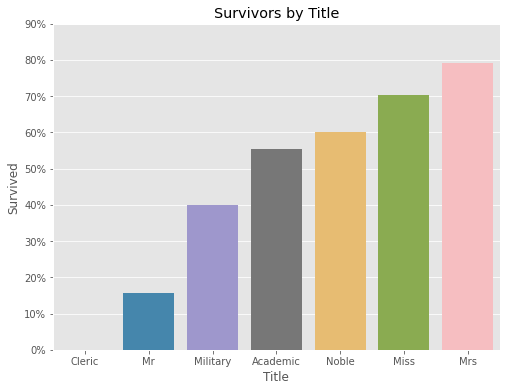

In [132]:

surv_title = df[["Survived", "Title"]].groupby(["Title"], as_index=False).mean().sort_values(by="Survived", ascending=True)
g = sns.barplot(x=surv_title["Title"], y=surv_title["Survived"]*100)
_ = g.set_title("Survivors by Title")
replace_labels(g, '%')
